# simu_file_handler の使い方サンプル（空間囚人のジレンマゲーム）
ここでは進化ゲームの応用の一種である空間囚人のジレンマゲームを扱って

In [39]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../")
import simu_file_handler as sh   # simu_file_handler を読み込む

import importlib
importlib.reload(sh)

<module 'simu_file_handler' from '../simu_file_handler.py'>

In [40]:
R, P = 1., 0.

class Parameter(sh.SParameter):
    def __init__(self, L=20, T=1.4, S=-0.4, mu=0.01, Tmax=1000, sd=None):
        super().__init__(sd)
        
        self.pdict['L'] = L
        self.pdict['T'] = T
        self.pdict['S'] = S
        self.pdict['mu'] = mu
        self.pdict['Tmax'] = Tmax

In [41]:
sfh = sh.SimuFileHandler('data_eg', Parameter())

In [58]:
class EvolGame:
    def __init__(self, param):
        self.pd = param.pdict
        L = self.pd['L']
        
        self.G = nx.grid_2d_graph(L, L, True)
        self.nodes = {n:{'strategy':'C','payoff':0.} for n in self.G.nodes}
        
        self.reset()
    
    
    def reset(self):
        self.t = 0
        
        for d in self.nodes.values():
            d['strategy'] = 'C' if np.random.rand() < 0.5 else 'D'
            d['payoff'] = 0.
    
    
    def play_game(self, f_i):
        global R, P
        T, S = self.pd['T'], self.pd['S']
        
        game = lambda mys, ops: {('C','C'):R, ('C','D'):S, ('D','C'):T, ('D','D'):P}[(mys,ops)]
        
        self.nodes[f_i]['payoff'] = 0.
        mys = self.nodes[f_i]['strategy']
        for a  in self.G.neighbors(f_i):
            ops = self.nodes[a]['strategy']
            self.nodes[f_i]['payoff'] += game(mys, ops)
            
            self.nodes[a]['payoff'] = 0.
            for aa in self.G.neighbors(a):
                ops2 = self.nodes[aa]['strategy']
                self.nodes[a]['payoff'] += game(ops, ops2)
    
    
    def update_strategy(self, f_i):
        mu = self.pd['mu']
        
        if np.random.rand() < mu:
            self.nodes[f_i]['strategy'] = 'C' if np.random.rand() < 0.5 else 'D'
        else:
            nlist = list([n for n in self.G.neighbors(f_i)])
            nlist.append(f_i)
        
            np.random.shuffle(nlist)#; print(nlist)
            imax = 0; rmax = self.nodes[nlist[0]]['payoff']
            for i in range(1,len(nlist)):
                if self.nodes[nlist[i]]['payoff'] > rmax:
                    imax = i
                    rmax = self.nodes[nlist[i]]['payoff']

            self.nodes[f_i]['strategy'] = self.nodes[nlist[imax]]['strategy']
    
    
    def calc_fc(self):
        N = int(self.pd['L']**2)
        nc = 0
        for d in self.nodes.values():
            nc += 1 if d['strategy']=='C' else 0
        
        return nc/N
    
    
    def execute_one_generation(self):
        L = self.pd['L']
        N = L*L
        
        for i in range(N):
            r = np.random.randint(N)
            f_i = (r//L,r%L)
            self.play_game(f_i)
            self.update_strategy(f_i)
    
    
    def execute(self, show=False):
        N = int(self.pd['L']**2)
        Tmax = self.pd['Tmax']
        arr = np.zeros(Tmax)
        
        for i in range(Tmax):
            self.execute_one_generation()
            arr[i] = self.calc_fc()
            
            if show:
                show_progress(i, Tmax, 10)
        
        print()
        return np.sum(arr[int(N*0.9):])/(N-int(N*0.9))   
            
            
            

def show_progress(i, MAX_ITER, length, fs='', bs=''):
    if i%(MAX_ITER/length) == 0:
        print(fs, "*"*int(i/(MAX_ITER/length)) + "_"*(length-int(i/(MAX_ITER/length))), \
              f"{int(i/MAX_ITER*100):3d}%", bs, end='\r')

In [59]:
param = Parameter(); print(param)

eg = EvolGame(param)
fc = eg.execute(show=True)
print(fc)

L20_T140_S-40_mu1_Tmax1000
 *********_  90% 
0.0828125


In [64]:
n = 1

tmp_param = Parameter(Tmax=500)

S_array = np.arange(-1.0, 1.05, 0.2)
T_array = np.arange(0.0,  2.05, 0.2)

for S_param in sh.ParamIterator(tmp_param, 'S', S_array):
    for T_param in sh.ParamIterator(S_param, 'T', T_array):
        print(T_param)
        eg = EvolGame(T_param)
        for i in range(n):
            eg.reset()
            fc = eg.execute(show=True)
            sfh.add_one_result(T_param, [fc])

L20_T0_S-100_mu1_Tmax500
 *********_  90% 
L20_T20_S-100_mu1_Tmax500
 *********_  90% 
L20_T40_S-100_mu1_Tmax500
 *********_  90% 
L20_T60_S-100_mu1_Tmax500
 *********_  90% 
L20_T80_S-100_mu1_Tmax500
 *********_  90% 
L20_T100_S-100_mu1_Tmax500
 *********_  90% 
L20_T120_S-100_mu1_Tmax500
 *********_  90% 
L20_T140_S-100_mu1_Tmax500
 *********_  90% 
L20_T160_S-100_mu1_Tmax500
 *********_  90% 
L20_T180_S-100_mu1_Tmax500
 *********_  90% 
L20_T200_S-100_mu1_Tmax500
 *********_  90% 
L20_T0_S-80_mu1_Tmax500
 *********_  90% 
L20_T20_S-80_mu1_Tmax500
 *********_  90% 
L20_T40_S-80_mu1_Tmax500
 *********_  90% 
L20_T60_S-80_mu1_Tmax500
 *********_  90% 
L20_T80_S-80_mu1_Tmax500
 *********_  90% 
L20_T100_S-80_mu1_Tmax500
 *********_  90% 
L20_T120_S-80_mu1_Tmax500
 *********_  90% 
L20_T140_S-80_mu1_Tmax500
 *********_  90% 
L20_T160_S-80_mu1_Tmax500
 *********_  90% 
L20_T180_S-80_mu1_Tmax500
 *********_  90% 
L20_T200_S-80_mu1_Tmax500
 *********_  90% 
L20_T0_S-60_mu1_Tmax500
 ********

Folder: data_eg
Parameter: ['L', 'T', 'S', 'mu', 'Tmax']

# of values that was set to each variable. 


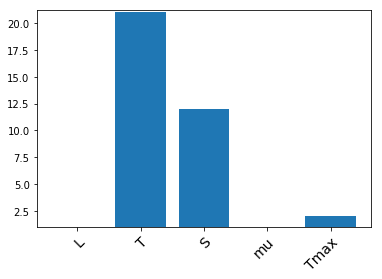

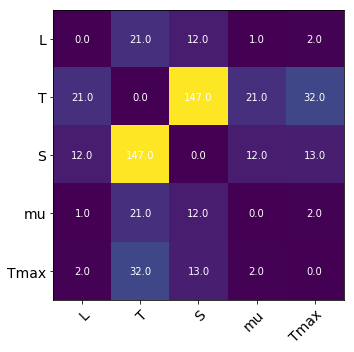

In [65]:
sfh.summary()